In [10]:
import os
#check current work dir
os.getcwd()
# #checkout word dir
os.chdir('./gdrive/MyDrive/ORF_detect')

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from seaborn import histplot
import math
import spacy
from collections import  Counter
from process.text_process import doc_process,text_clean,en_stopwords,replace_locName,has_money,count_links,replace_link,sent_process,remove_stopwords
from transformers import BertTokenizer

In [12]:
#set Java enviroment variable
spacy.require_gpu(0)
#loading nlp package
en_nlp=spacy.load('en_core_web_md')

pd.set_option('display.max_columns',None)
#read data
data_dir=r'./Data/fakeJob'
mode='train'
data_path='data.csv'
df=pd.read_csv(os.path.join(data_dir,mode,data_path),encoding='utf_8_sig')
htmlCol_names=['company_profile','description','requirements','benefits']
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14304 entries, 0 to 14303
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               14304 non-null  int64 
 1   title                14304 non-null  object
 2   location             14038 non-null  object
 3   department           5049 non-null   object
 4   salary_range         2310 non-null   object
 5   company_profile      11638 non-null  object
 6   description          14303 non-null  object
 7   requirements         12139 non-null  object
 8   benefits             8529 non-null   object
 9   telecommuting        14304 non-null  int64 
 10  has_company_logo     14304 non-null  int64 
 11  has_questions        14304 non-null  int64 
 12  employment_type      11531 non-null  object
 13  required_experience  8676 non-null   object
 14  required_education   7862 non-null   object
 15  industry             10381 non-null  object
 16  func

In [13]:
#remove duplicate data based on Job description
print('Before remove duplicat data shape:',df.shape)
df=df.drop_duplicates(subset=['description','title'],keep=False).reset_index(drop=True)
bool_df=df.copy().notna()#create bool df
print('after remove duplicated data shape:',df.shape)
#查看對於fraud & legtimate company profile 的empty數量
print('------legtimate exmaples info------------')
print(df.loc[df.fraudulent==0].info())
print('------Fruad exmaples info------------')
print(df.loc[df.fraudulent==1].info())

Before remove duplicat data shape: (14304, 18)
after remove duplicated data shape: (12176, 18)
------legtimate exmaples info------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11682 entries, 0 to 12175
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               11682 non-null  int64 
 1   title                11682 non-null  object
 2   location             11443 non-null  object
 3   department           4501 non-null   object
 4   salary_range         1940 non-null   object
 5   company_profile      9630 non-null   object
 6   description          11682 non-null  object
 7   requirements         10057 non-null  object
 8   benefits             6823 non-null   object
 9   telecommuting        11682 non-null  int64 
 10  has_company_logo     11682 non-null  int64 
 11  has_questions        11682 non-null  int64 
 12  employment_type      9348 non-null   object
 13  required_exper

In [14]:
#display duplicate text in text columns
def count_duplicateData(df_data,col_name,labels):
    print(f'--------------display duplicate data in {col_name}---------------')
    #filter dupicated data in columns 
    duplicated_data=df_data.loc[df_data[col_name].duplicated(keep=False),col_name].copy().dropna()
    duplicated_data=df_data.loc[duplicated_data.index]

    print('total duplicated data num:{}'.format(len(duplicated_data)))

    return duplicated_data.index

In [15]:
# print('-----Origin blank field in each column----')
# for c_name in htmlCol_names:
#     print(f'{c_name} fraud &legit number')
#     print(f'legit propotion:{sum(null_legitDf[c_name])/len(legitDf)} \t Fraud num:{sum(null_FraudDf[c_name])/len(FraudDf)}')

  label_names        location  percentage
0       Fraud   United States    0.847107
1       Fraud           Other    0.057851
2       Fraud       Australia    0.055785
3       Fraud  United Kingdom    0.020661
4       Fraud          Canada    0.018595
5       Legit   United States    0.559556
6       Legit           Other    0.250284
7       Legit  United Kingdom    0.152408
8       Legit          Canada    0.026741
9       Legit       Australia    0.011011
  label_names  telecommuting  percentage
0       Fraud              0    0.919028
1       Fraud              1    0.080972
2       Legit              0    0.960195
3       Legit              1    0.039805
  label_names  has_company_logo  percentage
0       Fraud                 0    0.694332
1       Fraud                 1    0.305668
2       Legit                 1    0.818182
3       Legit                 0    0.181818
  label_names  has_questions  percentage
0       Fraud              0    0.692308
1       Fraud              1   

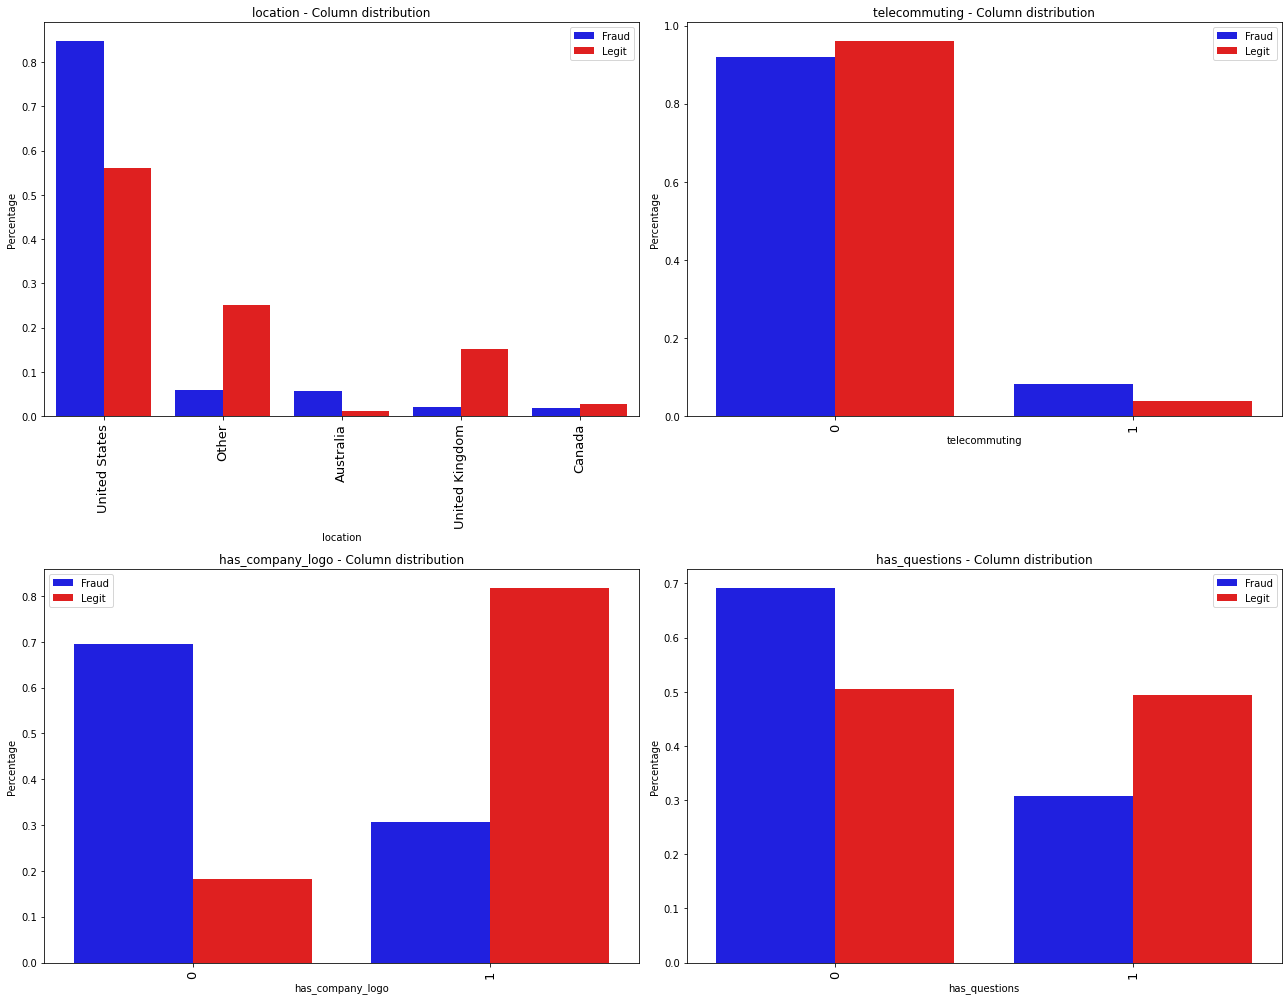

In [16]:
'''Explore Categorical data (Company logo,telecomuting,company_logo,question,location)distribution'''
def plot_percent(group_df,col_names):
    fig=plt.figure(figsize=(18,14))
    #compute row nums
    nrows=math.ceil(len(col_names)/2)
    for idx,name in enumerate(col_names):
        
        #compute group percentage
        counts=group_df[name].value_counts(normalize=True,dropna=True).rename('percentage').reset_index()
        print(counts)
        #plot percentage
        ax=fig.add_subplot(nrows,2,idx+1)
        p=sns.barplot(x=name,y='percentage',hue='label_names',data=counts,ax=ax,palette={'Fraud':'b','Legit':'r'})
        plt.setp(p.get_xticklabels(),rotation=90,fontsize=13)
        ax.set_title(f'{name} - Column distribution')
        ax.set_ylabel('Percentage')
        ax.legend()
    fig.tight_layout()
    plt.show()
#change label name
Id2Label={1:'Fraud',0:'Legit'}
df['label_names']=df['fraudulent'].apply(lambda x:Id2Label[x])
df.fillna(value={'company_profile':'','description':'','requirements':'','benefits':''},inplace=True)
#change country names
df['location']=df['location'].dropna().apply(lambda x: replace_locName(x))
#detect title whether has money
df['title_has_money']=df['title'].apply(lambda x:has_money(x))
df['complete_job_attr']=bool_df.loc[:,['required_experience','required_education','industry','function']].all(axis=1)
df['salary_filled']=bool_df.loc[:,'salary_range']
df['employ_filled']=bool_df.loc[:,'employment_type']
#Grouped data
group_df=df.groupby(['label_names'])
plot_percent(group_df,['location','telecommuting','has_company_logo','has_questions'])


   label_names                 required_education  percentage
0        Fraud          High School or equivalent    0.387755
1        Fraud                  Bachelor's Degree    0.216327
2        Fraud                        Unspecified    0.167347
3        Fraud                    Master's Degree    0.065306
4        Fraud        Some High School Coursework    0.065306
5        Fraud                      Certification    0.053061
6        Fraud                   Associate Degree    0.016327
7        Fraud                       Professional    0.012245
8        Fraud  Some College Coursework Completed    0.012245
9        Fraud                          Doctorate    0.004082
10       Legit                  Bachelor's Degree    0.527253
11       Legit          High School or equivalent    0.192754
12       Legit                        Unspecified    0.153504
13       Legit                    Master's Degree    0.047195
14       Legit                   Associate Degree    0.029557
15      

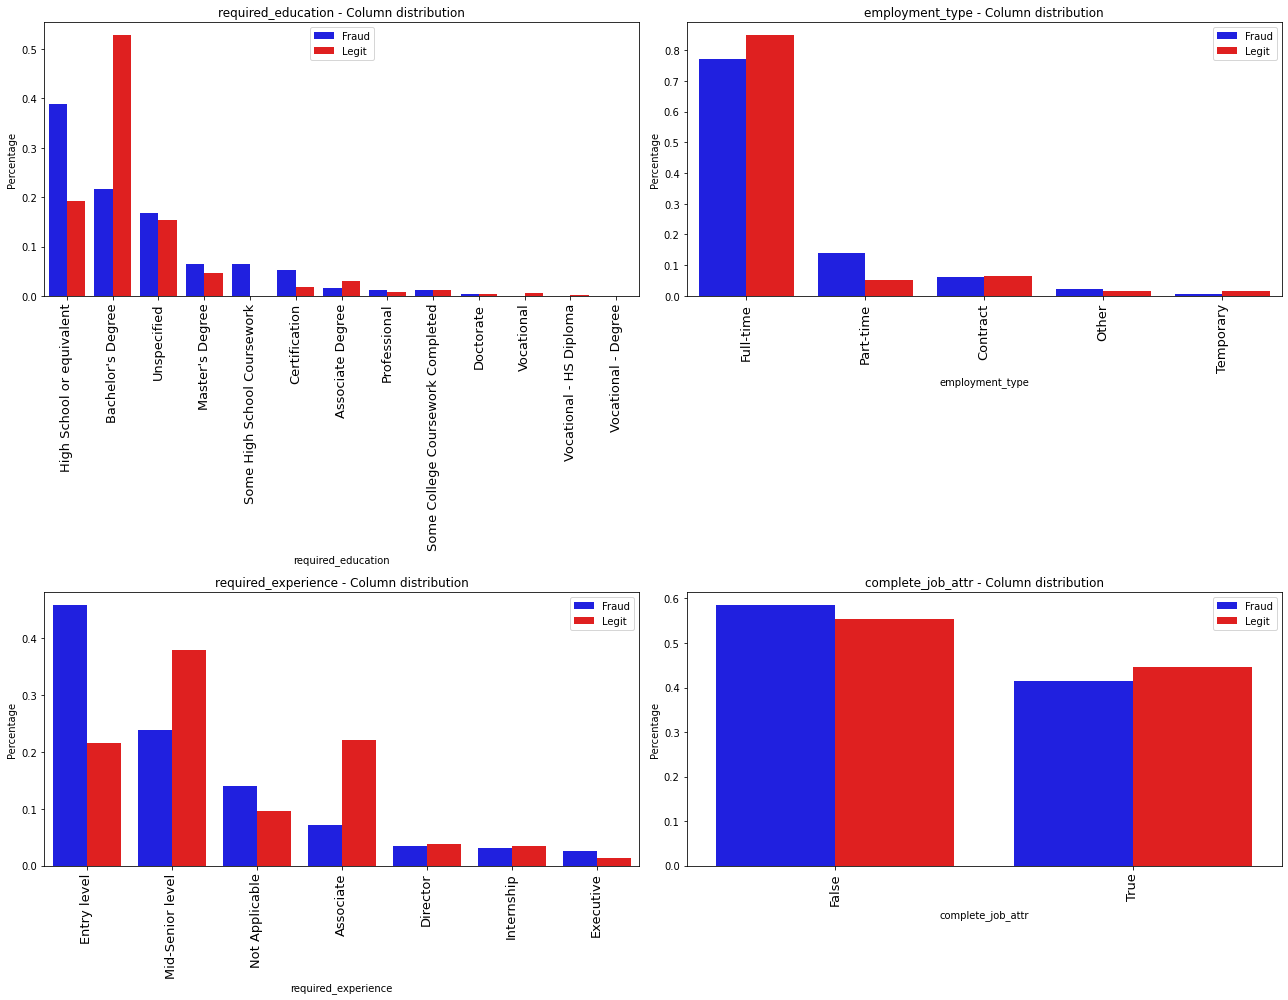

  label_names  salary_filled  percentage
0       Fraud          False    0.708502
1       Fraud           True    0.291498
2       Legit          False    0.833933
3       Legit           True    0.166067
  label_names  employ_filled  percentage
0       Fraud           True    0.757085
1       Fraud          False    0.242915
2       Legit           True    0.800205
3       Legit          False    0.199795
  label_names  title_has_money  percentage
0       Fraud                0    0.981781
1       Fraud                1    0.018219
2       Legit                0    0.996576
3       Legit                1    0.003424


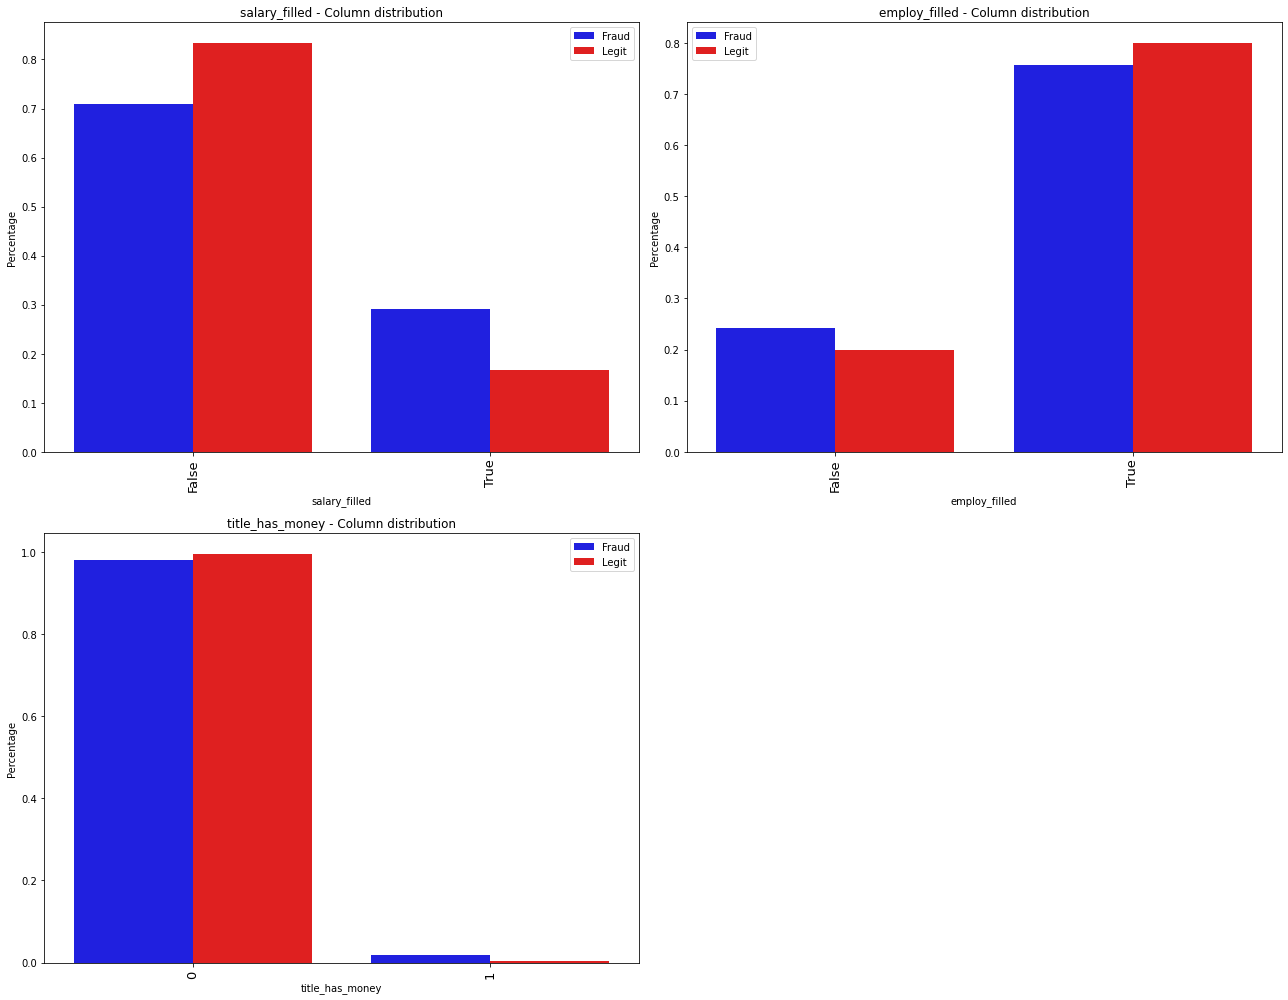

In [17]:
plot_percent(group_df,['required_education','employment_type','required_experience','complete_job_attr'])
plot_percent(group_df,['salary_filled','employ_filled','title_has_money'])

In [18]:
'''exploratory data info. for 4 columns(company profile,desrciption,requirement,benefit)'''
def create_x(dfs,column_names,axis=1):
    x_Data=[]
    for c_name in column_names:
        #storage fraud &legti data
        combined_data=[df.loc[:,c_name].values for df in dfs]
        x_Data.append(combined_data)
    return x_Data
'''Exploratory html string data'''
#select specific column
df_text=df.select_dtypes(include='object')
#remain html tag column (company_profile,description,requirement,benefits)
df_text=df_text.drop([c_name for c_name in df_text.columns if c_name not in htmlCol_names],axis=1)
#combine label data
df_text=pd.concat([df_text,df['label_names'].copy()],axis=1)
#text process in text columns
for col in htmlCol_names:
  #text process
  df_text[col+'_clean']=df_text[col].apply(lambda x:text_clean(x))
  #segmentation text
  df_text[col+'_doc']=df_text[col+'_clean'].apply(lambda x:en_nlp(x) if x else '')

In [32]:
#create  text Num for each columns(company_profile,job_description,requirement,benefit) 
for c_name in htmlCol_names:
  df_text[c_name+'_link_counts']=df_text[c_name+'_clean'].apply(lambda x:count_links(x))
  df_text[c_name+'_tokenized']=df_text[c_name+'_doc'].apply(lambda x:doc_process(x) if x else [])
  df_text[c_name+'_WordNum']=df_text[c_name+'_tokenized'].apply(lambda x:len([w for sent in x for w in sent]))
  df_text[c_name+'_sentNum']=df_text[c_name+'_doc'].apply(lambda x:len([s.text for s in x.sents]) if x else 0)
  df_text[c_name+'_posNum']=df_text[c_name+'_doc'].apply(lambda x:len([t.tag_ for t in x if t.tag_.startswith(('J','RB'))]) if x else 0)

In [33]:
#set axes text annotate
def autolabel(rects,ax):
    for rect in rects:
        height=rect.get_height()
        ax.annotate(
            '{:.3f}'.format(height),
            xy=(rect.get_x()+rect.get_width()/2,height),
            xytext=(0,3),
            textcoords='offset points',
            ha='center',va='bottom')
#define bar plot
def FreqHistPlot(data,column_names,title,n_cols=2,width=0.3,bins=15):
    #get row num
    n_rows=math.ceil(len(column_names)/n_cols)
    #build figure
    fig=plt.figure(figsize=(20,20))
    for i,c_name in enumerate(column_names):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax=histplot(x=data[c_name],hue=data['label_names'],ax=ax,stat='probability',common_norm=False,
                        element='step',palette={'Fraud':'b','Legit':'r'},multiple='dodge')

        ax.set_xlabel('Word nums Range')
        ax.set_ylabel('Occurane percentage')
        ax.set_title(title+f'{c_name}')

    fig.tight_layout()
    plt.show()

In [34]:
#display describe statistical in Word  & sent Num
fraud_df=df_text.loc[df_text['label_names']=='Fraud',:]
legit_df=df_text.loc[df_text['label_names']=='Legit',:]

def display_describe(fraud_data,legit_df,columns):
    for c_name in columns:
        print(f'====Display describe statistics in {c_name}====')
        print('Fraud_df:\n{}\n'.format(fraud_data[c_name].describe()))
        print('Legit_df:\n{}\n'.format(legit_df[c_name].describe()))

display_describe(fraud_df,legit_df,[c_name+'_WordNum' for c_name in htmlCol_names])
display_describe(fraud_df,legit_df,[c_name+'_sentNum' for c_name in htmlCol_names])
display_describe(fraud_df,legit_df,[c_name+'_link_counts' for c_name in htmlCol_names])
display_describe(fraud_df,legit_df,[c_name+'_posNum' for c_name in htmlCol_names])

====Display describe statistics in company_profile_WordNum====
Fraud_df:
count    494.000000
mean      25.556680
std       46.032353
min        0.000000
25%        0.000000
50%        0.000000
75%       48.000000
max      186.000000
Name: company_profile_WordNum, dtype: float64

Legit_df:
count    11682.000000
mean        91.960024
std         82.642992
min          0.000000
25%         33.000000
50%         78.000000
75%        125.000000
max        820.000000
Name: company_profile_WordNum, dtype: float64

====Display describe statistics in description_WordNum====
Fraud_df:
count     494.000000
mean      156.317814
std       133.766524
min         0.000000
25%        65.000000
50%       113.000000
75%       203.750000
max      1030.000000
Name: description_WordNum, dtype: float64

Legit_df:
count    11682.000000
mean       170.313816
std        120.415911
min          0.000000
25%         87.000000
50%        148.000000
75%        223.000000
max       1872.000000
Name: description_Wor

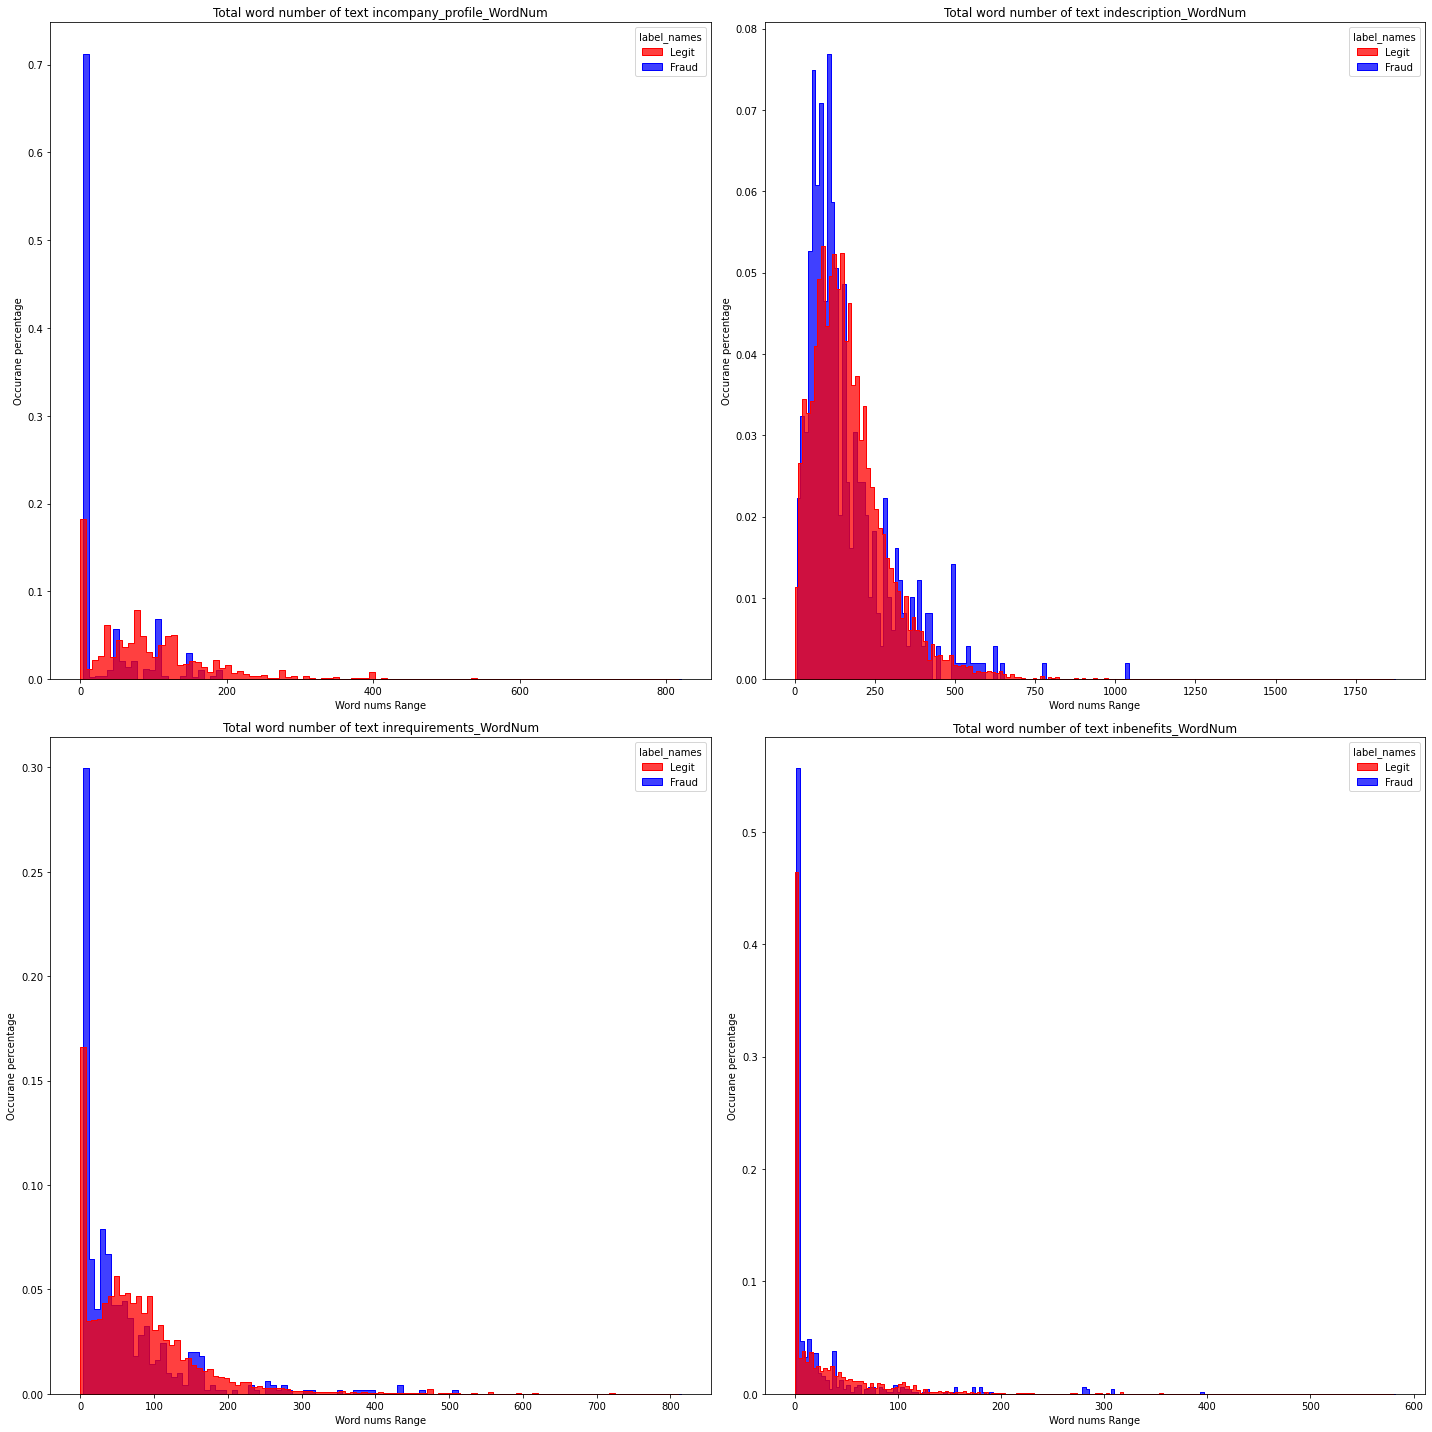

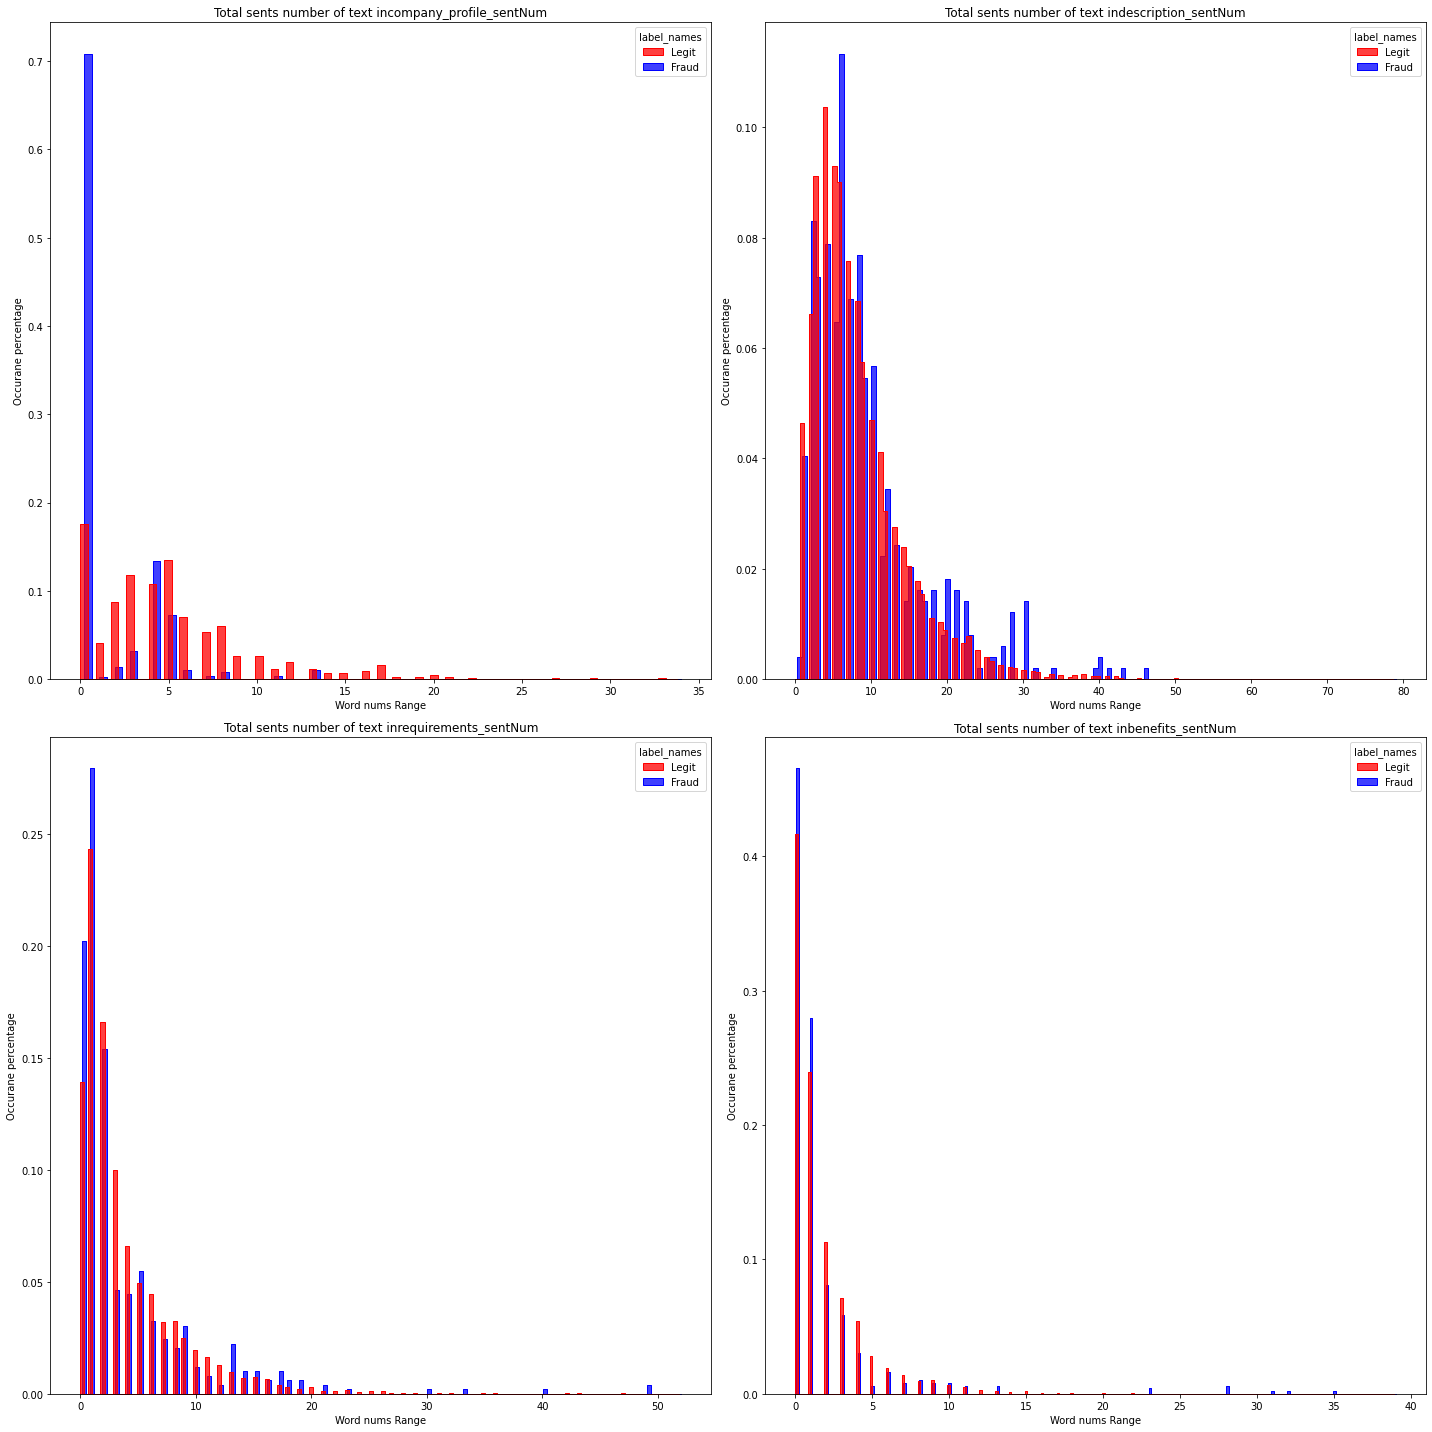

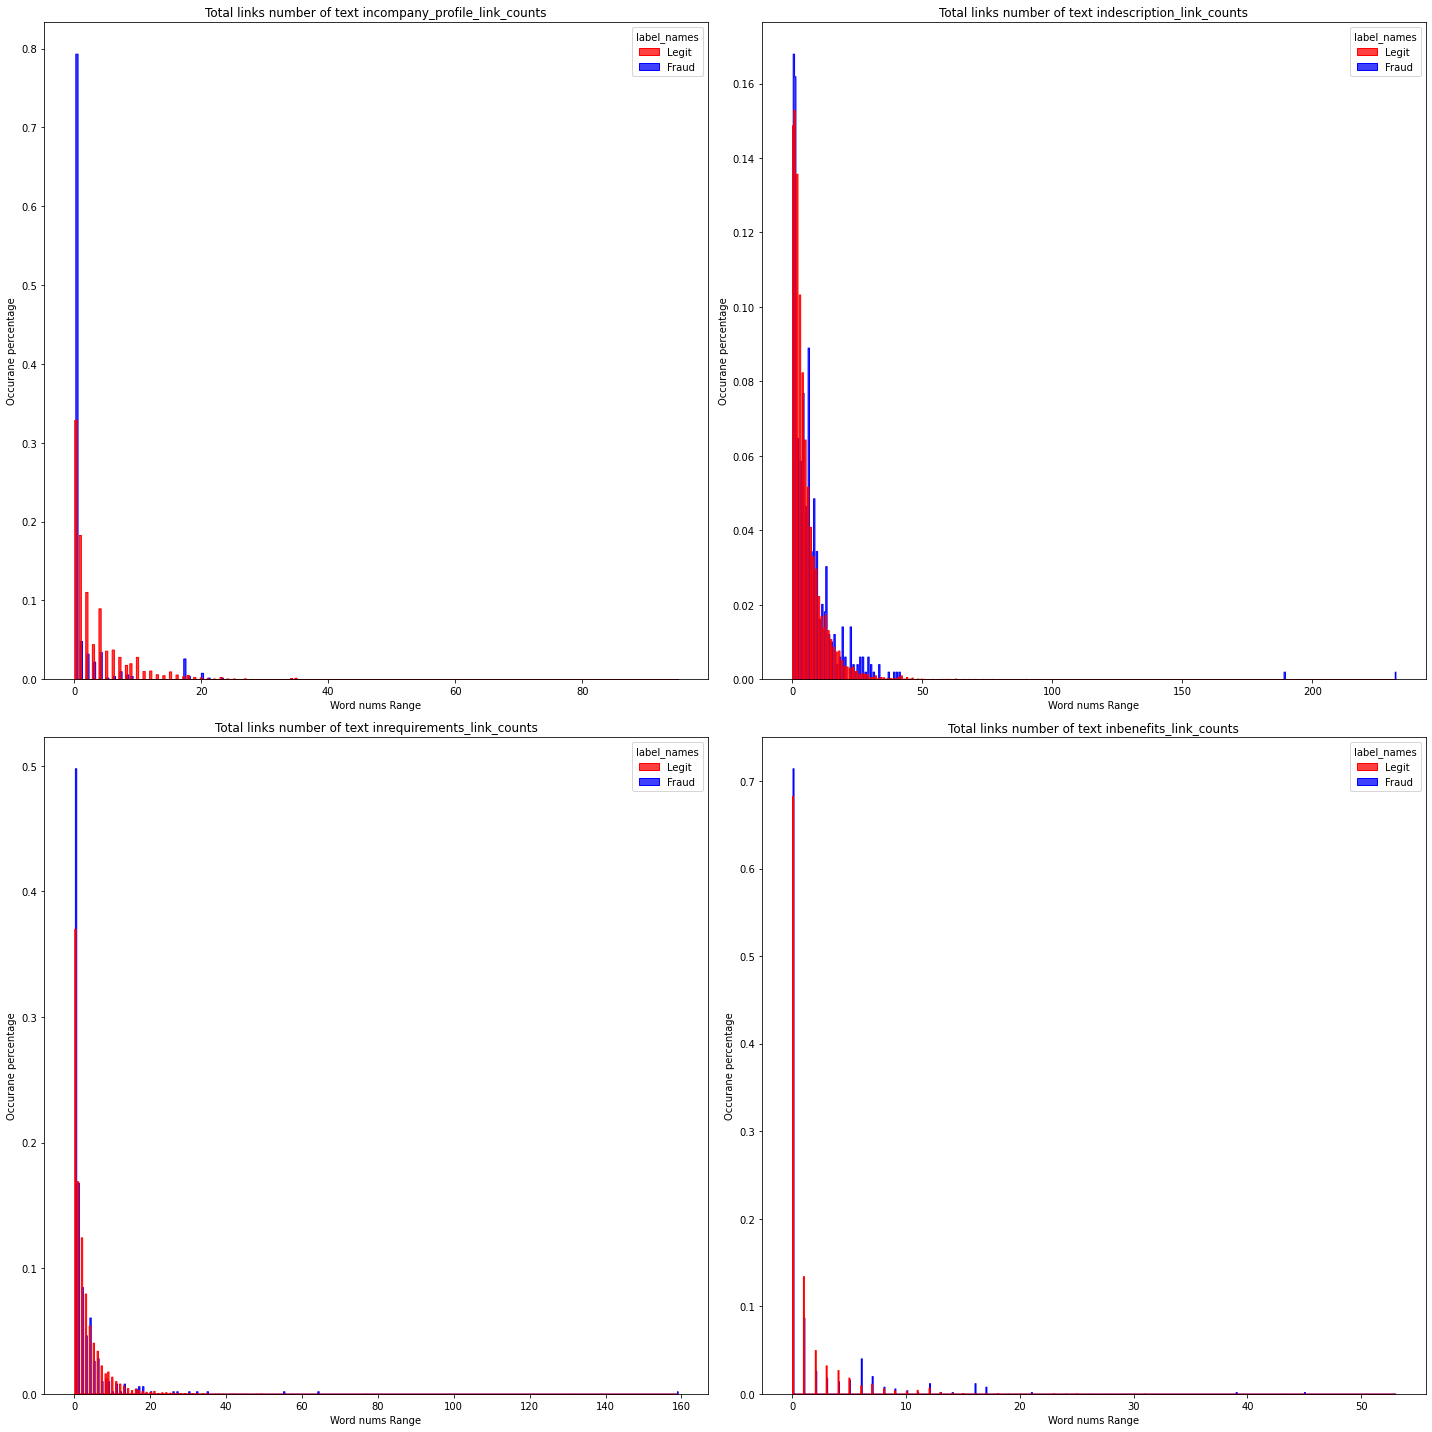

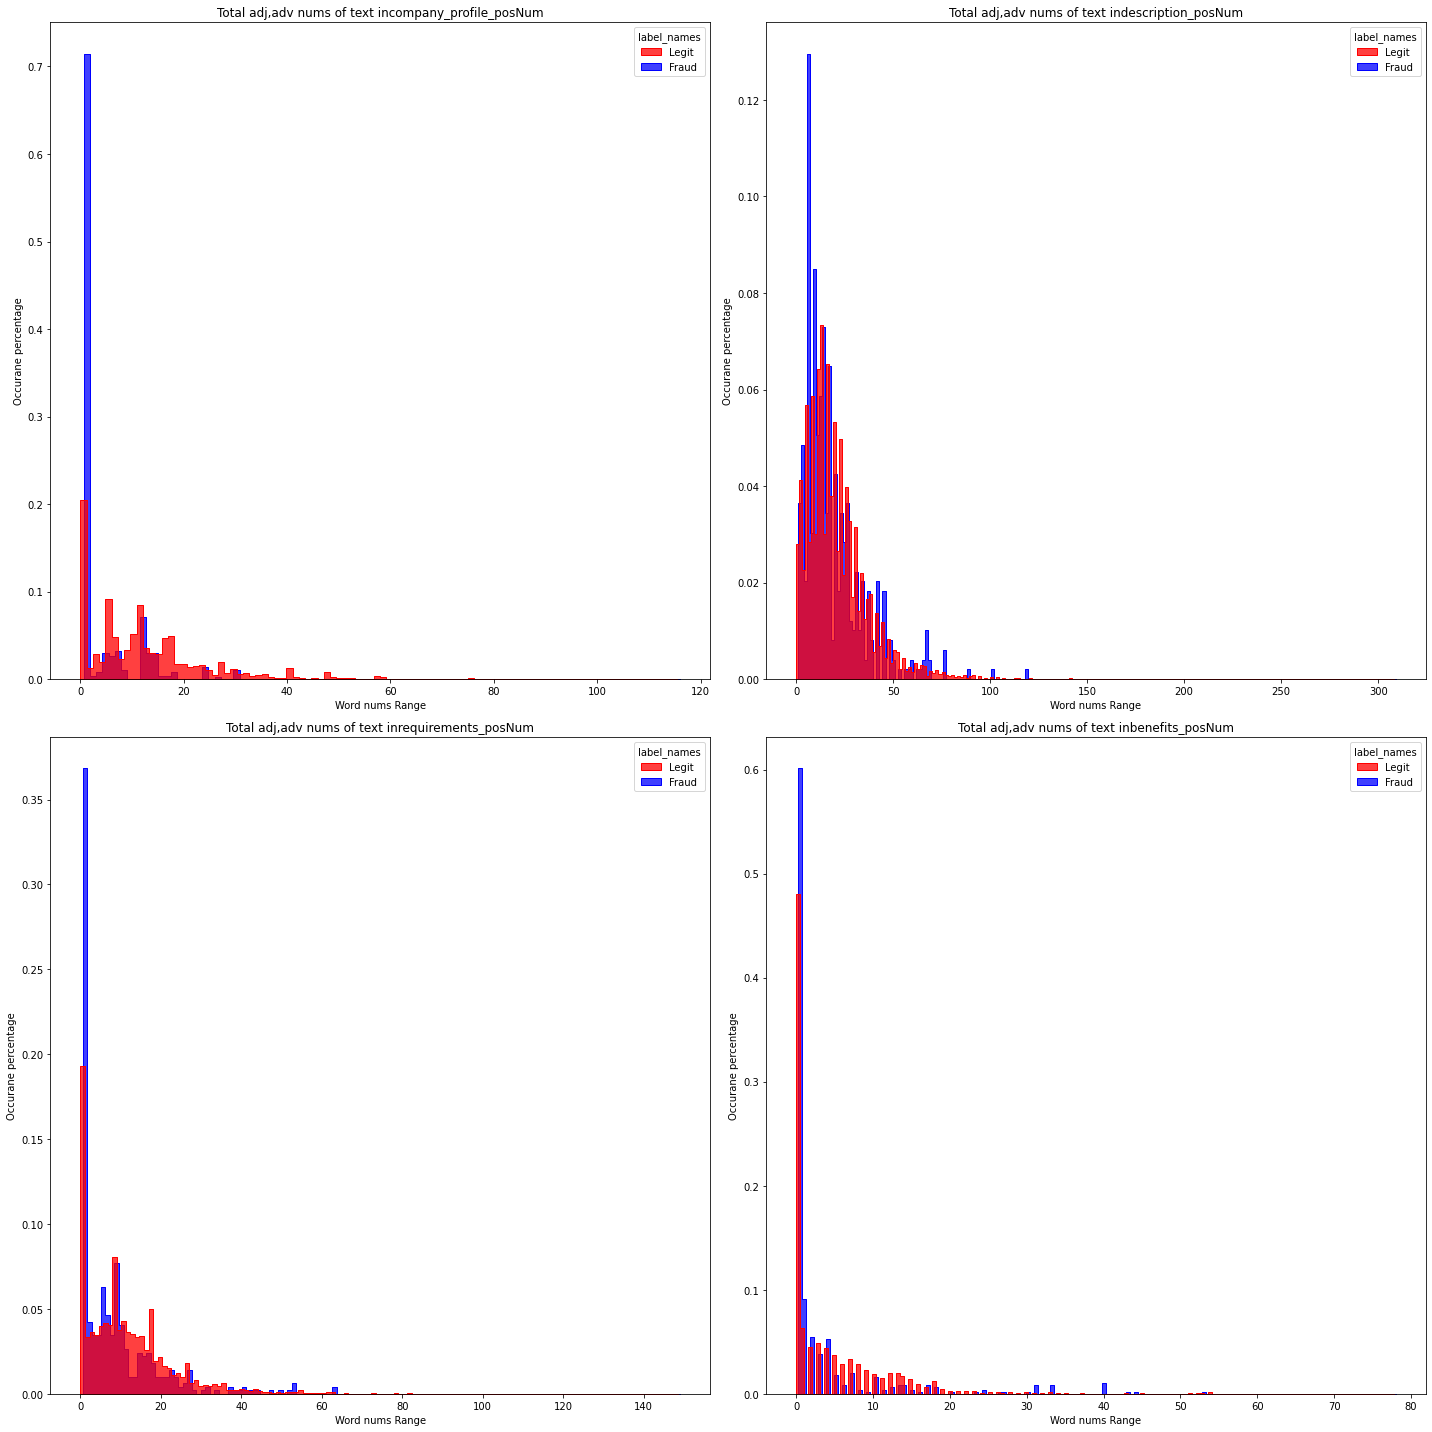

In [35]:
#display hitsogram bar plot for each wordNum columns(company_profile,job_description,requirement,benefit)
FreqHistPlot(df_text,[c_name+'_WordNum' for c_name in htmlCol_names],'Total word number of text in')
FreqHistPlot(df_text,[c_name+'_sentNum' for c_name in htmlCol_names],'Total sents number of text in')
FreqHistPlot(df_text,[c_name+'_link_counts' for c_name in htmlCol_names],'Total links number of text in')
FreqHistPlot(df_text,[c_name+'_posNum' for c_name in htmlCol_names],'Total adj,adv nums of text in')

In [36]:
def plot_radarChart(y_values,y_ticks,markers,lineStyles,colors,labels,x_ticklabels,title):
  N=len(x_ticklabels)
  #create x_angles
  x_angles=[i/N*2*math.pi for i in range(N)]
  x_angles+=x_angles[:1]
  #build figure 
  fig=plt.figure(figsize=(12,10))
  ax=fig.add_subplot(1,1,1,polar=True)
  for y,m,c,l,ls in zip(y_values,markers,colors,labels,lineStyles):
    y=np.concatenate((y,y[:1]),axis=0)
    plt.polar(x_angles,y,ls=ls,color=c,marker=m,label=l)
    plt.xticks(x_angles[:-1],x_ticklabels)
    plt.yticks(y_ticks,color='gray',size=10)
    plt.title(title)
    plt.legend()
  plt.show()
def count_wordFreq(corpus):
  #build word set
  tokens=[w for doc in corpus for sent in doc for w in sent]
  token_counts=Counter(tokens)
  return token_counts

In [37]:
#compute common word numbers
common_wordList=[]
for c_name in htmlCol_names:
  legit_common=count_wordFreq(legit_df[c_name+'_tokenized'].values.tolist())
  fraud_common=count_wordFreq(fraud_df[c_name+'_tokenized'].values.tolist())
  print(f'Collect common word in {c_name} success!')
  common_wordList.append((legit_common,fraud_common))

Collect common word in company_profile success!
Collect common word in description success!
Collect common word in requirements success!
Collect common word in benefits success!


In [38]:
print(common_wordList[0][0].most_common())
print(common_wordList[0][1].most_common())

[('and', 56632), ('the', 40875), ('to', 34323), ('be', 32479), ('we', 28646), ('of', 26391), ('a', 25883), ('in', 23565), ('our', 19218), ('for', 14048), ('with', 12511), ('that', 9980), ('you', 8303), ('have', 7844), ('company', 7550), ('work', 7364), ('on', 7143), ('s', 6543), ('as', 6313), ('team', 5856), ('their', 5612), ('service', 5021), ('an', 4973), ('it', 4925), ('by', 4742), ('people', 4724), ('business', 4536), ('at', 4457), ('from', 4418), ('re', 4129), ('client', 4095), ('provide', 4003), ('technology', 3761), ('world', 3710), ('customer', 3692), ('solution', 3540), ('your', 3533), ('help', 3286), ('all', 3099), ('make', 3030), ('grow', 2878), ('product', 2861), ('they', 2798), ('who', 2721), ('experience', 2612), ('new', 2561), ('well', 2546), ('can', 2505), ('process', 2419), ('more', 2419), ('good', 2419), ('build', 2394), ('employee', 2376), ('great', 2366), ('create', 2358), ('deliver', 2351), ('time', 2349), ('about', 2327), ('offer', 2284), ('need', 2259), ('through

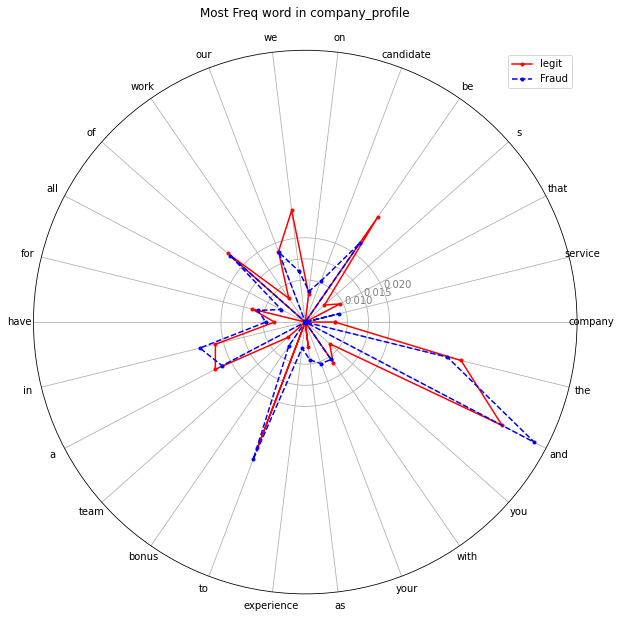

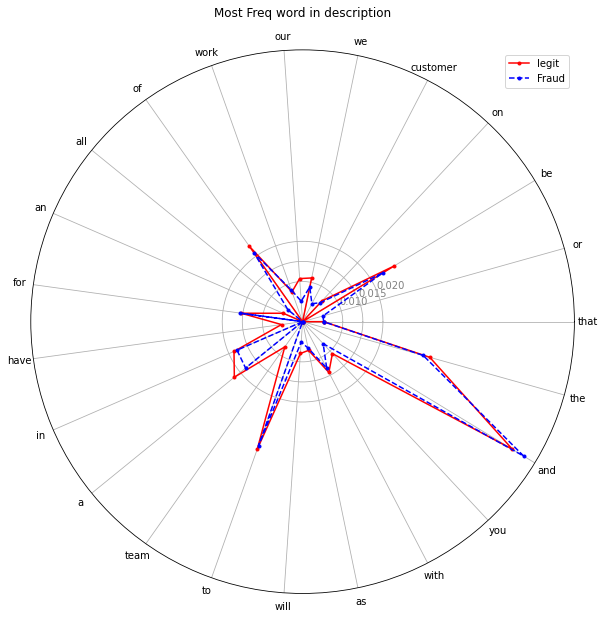

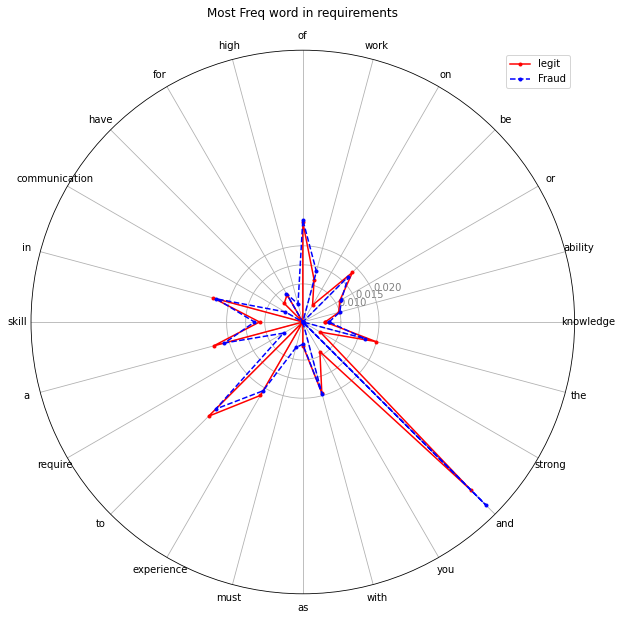

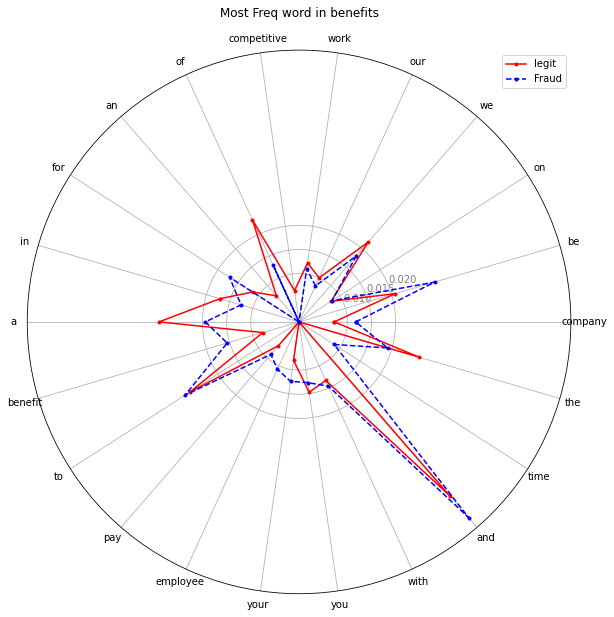

In [39]:
for c_name,common_word in zip(htmlCol_names,common_wordList):
    #compute total words num
    legit_totalNum=len(list(common_word[0].elements()))
    fraud_totalNum=len(list(common_word[1].elements()))

    #create x_labels
    legit_common=dict(common_word[0].most_common(20))
    fraud_common=dict(common_word[1].most_common(20))
    x_ticklabels=[w for w in set(legit_common.keys()).union(set(fraud_common.keys()))]
    #create y_labels
    y_fraud=np.array([int(fraud_common.get(w,0))/fraud_totalNum for w in x_ticklabels])
    y_legit=np.array([int(legit_common.get(w,0))/legit_totalNum for w in x_ticklabels])

    y_ticks=[0.01,0.015,0.02]
    y_values=[y_legit,y_fraud]
    markers=['.','.']
    colors=['r','b']
    labels=['legit','Fraud']
    lineStyles=['-','--']
    title=f'Most Freq word in {c_name}'
    plot_radarChart(y_values,y_ticks,markers,lineStyles,colors,labels,x_ticklabels,title)

In [40]:
#build bert tokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
print('Before add:{}'.format(len(tokenizer)))
#add new token
spec_tokens=['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP','ORDINAL','ORG','PERCENT',
      'PERSON','PRODUCT','QUANTITY','TIME','WORK_OF_ART']
new_tokens_num=tokenizer.add_tokens(spec_tokens,special_tokens=True)
print('add new token num:',new_tokens_num)
print('add tokens:',tokenizer.get_added_vocab())
print('After add:{}'.format(len(tokenizer)))
tokenizer.additional_special_tokens=['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP','ORDINAL','ORG','PERCENT',
      'PERSON','PRODUCT','QUANTITY','TIME','WORK_OF_ART']

def bert_tokenized(sent):
  tokenized_sent=[]
  for w in sent:
    subwords=tokenizer.tokenize(w)
    if not subwords:
      subwords=[tokenizer.unk_token]
    tokenized_sent.extend(subwords)
  
  return tokenized_sent

Before add:30522
add new token num: 18
add tokens: {'CARDINAL': 30522, 'DATE': 30523, 'EVENT': 30524, 'FAC': 30525, 'GPE': 30526, 'LANGUAGE': 30527, 'LAW': 30528, 'LOC': 30529, 'MONEY': 30530, 'NORP': 30531, 'ORDINAL': 30532, 'ORG': 30533, 'PERCENT': 30534, 'PERSON': 30535, 'PRODUCT': 30536, 'QUANTITY': 30537, 'TIME': 30538, 'WORK_OF_ART': 30539}
After add:30540


In [41]:
tokenizer.tokenize('GPE')

['GPE']

In [42]:
#compute max word num
max_sentNum=[7,11,5,3]
for c_name,sentNum in zip(htmlCol_names,max_sentNum):
  df_text[c_name+'_rawSents']=df_text[c_name+'_doc'].apply(lambda x:[sent for sent in x.sents] if x else [])
  df_text[c_name+'_tokeniedSent']=df_text[c_name+'_rawSents'].apply(lambda x:[remove_stopwords(sent_process(sent)) for sent in x] if x else [])
  df_text[c_name+'_bert_tokenized']=df_text[c_name+'_tokeniedSent'].apply(lambda x:[bert_tokenized(sent) for sent in x[:sentNum]] if x else [])
  df_text[c_name+'_maxWord']=df_text[c_name+'_bert_tokenized'].apply(lambda x:sum(len(sent) for sent in x) if x else 0)

In [43]:
print(df_text['description_bert_tokenized'])

0        [[we, re, on, a, mission, to, identify, a, sma...
1        [[be, search, for, if, you, be, a, qualified, ...
2        [[the, vice, president, of, primary, responsib...
3        [[medium, monks, be, look, beyond, its, server...
4        [[will, be, base, in, our, client, location], ...
                               ...                        
12171    [[will, be, base, in], [the, right, candidate,...
12172    [[we, currently, have, a, vacancy, for, a, flu...
12173    [[i, be, look, for, goal, orient, business, sa...
12174    [[a, rep, ##utable, group, deliver, me, ##asur...
12175    [[we, be, look, for, a, web, developer, who, w...
Name: description_bert_tokenized, Length: 12176, dtype: object


In [44]:
#check max word Num
for c_name in htmlCol_names:
  describe=df_text[c_name+'_maxWord'].describe()
  print(f'{c_name} max word number:{describe}')

company_profile max word number:count    12176.000000
mean        75.693495
std         54.518157
min          0.000000
25%         31.000000
50%         81.000000
75%        120.000000
max        288.000000
Name: company_profile_maxWord, dtype: float64
description max word number:count    12176.000000
mean       150.476265
std         82.501195
min          0.000000
25%         90.000000
50%        146.000000
75%        200.000000
max        854.000000
Name: description_maxWord, dtype: float64
requirements max word number:count    12176.000000
mean        65.384363
std         55.937023
min          0.000000
25%         24.000000
50%         58.000000
75%         92.000000
max        624.000000
Name: requirements_maxWord, dtype: float64
benefits max word number:count    12176.000000
mean        21.285726
std         28.990788
min          0.000000
25%          0.000000
50%          7.000000
75%         36.000000
max        202.000000
Name: benefits_maxWord, dtype: float64
